# Final Team Project - SliceWise: Pricing, Menu, and Ratings Analytics for U.S. Pizza Restaurants 

### Team 9: Duy-Anh Dang, Arjun Venkatesh, and Nanch Walker 

Course: ADS 505 Applied Data Science for Business

Instructor: Jules Malin

## Introduction

## Problem Statement

Using the Datafiniti “Pizza Restaurants and the Pizza They Sell (May 2019)” dataset, we will deliver pricing and assortment insights for pizza operators.  

Objectives: 

 

    Profile geographic coverage and market density. 

    Quantify price corridors (store-level priceRangeMin/Max; item-level menus.amountMin/Max). 

    Identify outliers and dispersion by state/city and common SKUs. 

    Provide executive recommendations on pricing, assortment focus, and expansion targets. 

## Exploratory Data Analysis

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OneHotEncoder # preprocessing for numerical and categorical data
from sklearn.compose import ColumnTransformer # to apply different preprocessing to different columns
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV # hyperparameter tuning

from imblearn.over_sampling import SMOTENC # imblearn for handling class imbalance
from imblearn.pipeline import Pipeline # imblearn pipeline to handle resampling within cross-validation

from dateutil import parser # for parsing date strings

import kagglehub # to access Kaggle datasets
import os # to manage file paths

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("datafiniti/pizza-restaurants-and-the-pizza-they-sell")

print("Path to dataset files:", path)

Path to dataset files: /Users/nancywalker/.cache/kagglehub/datasets/datafiniti/pizza-restaurants-and-the-pizza-they-sell/versions/2


In [3]:
#Files downloaded
files = os.listdir(path)

In [4]:
# Select the first CSV file (assuming it exists)
csv_files = [f for f in files if f.endswith(".csv")] # Get all CSV file

# Load the first CSV file found
# data1 = pd.read_csv(os.path.join(path, csv_files[0]))
# Have not used this dataset for analysis

# Load the second dataset
data2 = pd.read_csv(os.path.join(path, csv_files[1]))

In [5]:
# print the first few rows of the first dataset
# print(data1.head()) 
# Have not used this dataset for analysis

In [6]:
# print the first few rows of the second dataset
print(data2.head())

                     id             dateAdded           dateUpdated  \
0  AVz3Y-7h3D1zeR_xDAqm  2017-06-30T05:05:40Z  2019-05-01T15:43:09Z   
1  AVweGPFF_7pvs4fzAAzQ  2016-04-02T04:02:49Z  2019-05-01T15:27:50Z   
2  AVwdRGa9_7pvs4fz4E3K  2016-03-03T18:39:49Z  2019-05-01T12:52:25Z   
3  AVwdX4psIN2L1WUfvJB1  2016-03-29T05:08:59Z  2019-05-01T12:52:20Z   
4  AVwdaeTtkufWRAb55pSH  2016-03-31T02:34:04Z  2019-05-01T12:50:45Z   

             address                                         categories  \
0   4203 E Kiehl Ave  Pizza,Restaurant,American restaurants,Pizza Pl...   
1  25 E Camelback Rd                      Pizza,Pizza Place,Restaurants   
2    3703 Paxton Ave                 Restaurant,Pizza Place,Restaurants   
3    30495 John R Rd       Pizza,Carry-out food,Pizza Place,Restaurants   
4   3600 Eastern Ave  Pizza,American restaurants,Pizza Place,Pizza e...   

               primaryCategories             city country  \
0  Accommodation & Food Services         Sherwood      US   


Two possible datasets can be used for this project.

data1 is a list of over 3,500 pizzas from multiple restaurants. 
- curated dataset of pizza-only restaurants in Datafiniti's business database. 
- Useful for pizza-specific analyses.

Data2 is a list of 10,000 pizza restaurants in Datafiniti's business database, spanning **from January 2018 to May 2019**.
- a larger, broader subset of Datafiniti's business database.
- useful to analyze pizza restaurants in comparison to other types of restaurants.

In [7]:
# data1.info() # Have not used this dataset for analysis
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10000 non-null  object 
 1   dateAdded           10000 non-null  object 
 2   dateUpdated         10000 non-null  object 
 3   address             10000 non-null  object 
 4   categories          10000 non-null  object 
 5   primaryCategories   10000 non-null  object 
 6   city                10000 non-null  object 
 7   country             10000 non-null  object 
 8   keys                10000 non-null  object 
 9   latitude            10000 non-null  float64
 10  longitude           10000 non-null  float64
 11  menuPageURL         1679 non-null   object 
 12  menus.amountMax     10000 non-null  float64
 13  menus.amountMin     10000 non-null  float64
 14  menus.currency      10000 non-null  object 
 15  menus.dateSeen      10000 non-null  object 
 16  menus

Two possible datasets. 

Dataset 1: 8358_1.csv 
- This dataset contains information on pizza restaurants and the types of Pizza they sell.
- It has 3,519 rows and 21 columns.
- There are a few features with missing values.

Dataset 2: Datafiniti_Pizza_Restaurants_and_the_Pizza_They_Sell_May19.csv
- list of 10,000 restaurants in Datafiniti's business database between January 2018 and May 2019
- There are 24 feature columns
- Business listings include a variation of the phrase Pizza within the categories and menu.name variables 
- fields have been flattened to make it easier to work with
- This dataset is a sample of a larger dataset that is available through Datafiniti's business database.


## Data2 Datafiniti Pizza Restaurants and the Pizza They Sell (May19)

In [8]:
# Data distribution
data2.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,10000.0,38.371895,4.573537,21.421326,34.422946,40.118880,40.905048,64.85050
longitude,10000.0,-90.063800,17.340379,-157.802443,-104.801126,-82.909949,-75.194741,-71.94617
menus.amountMax,10000.0,14.032670,17.607233,0.000000,8.490000,13.390000,17.950000,1395.00000
menus.amountMin,10000.0,13.416902,10.742678,0.000000,8.000000,12.990000,16.990000,243.00000
priceRangeMin,10000.0,4.655500,9.828412,0.000000,0.000000,0.000000,0.000000,50.00000
priceRangeMax,10000.0,27.764200,6.017526,7.000000,25.000000,25.000000,25.000000,55.00000


In [9]:
# Check for missing values
data2.isnull().sum()

id                       0
dateAdded                0
dateUpdated              0
address                  0
categories               0
primaryCategories        0
city                     0
country                  0
keys                     0
latitude                 0
longitude                0
menuPageURL           8321
menus.amountMax          0
menus.amountMin          0
menus.currency           0
menus.dateSeen           0
menus.description     6282
menus.name               0
name                     0
postalCode               4
priceRangeCurrency       0
priceRangeMin            0
priceRangeMax            0
province                 0
dtype: int64

There are a few features with missing values.

**Data2 Missing Values and Proposed Treatments:**

There are tree features with missing values in dataset 2. 

- menuPageURL - 8,321 missing values ( Identifier/Link to the menu page on the business's website), leave as null and drop column
- menus.description - 6,282 missing values ( Description of the menu item)
    - Options: drop column, impute with placeholder string (for NLP), or transform to binary variable
- postalCode - 4 missing values ( Postal code of the business), impute with mode


*Data1 Missing Values and Proposed Treatments: (for reference only, have not used this dataset for analysis)*

- *menuPageURL - 2,900 missing values ( Identifier/Link to the menu page on the business's website), leave as null and drop column*
- *menu.amountMax - 562 missing values ( Maximum price of the menu item), impute with median*
- *menus.amountMin - 562 missing values ( Minimum price of the menu item), impute with median*
- *menus.currency - 559 missing values ( Currency of the menu item price), impute with mode*
- *menus.description - 1984 missing values ( Description of the menu item)*
    - *Options: drop column, impute with placeholder string (for NLP), or transform to binary variable*
- *postalCode - 26 missing values ( Postal code of the business), impute with mode*
- *priceRangeCurrency - 1953 missing values ( Currency of the price range), impute with mode*
- *priceRangeMin - 1953 missing values ( Minimum price of the price range), impute with median*
- *priceRangeMax - 1953 missing values ( Maximum price of the price range), impute with median*


In [10]:
# Remove identifier columns for modeling
data2_cleaned = data2.drop(columns=['id', 'categories', 'address', 'keys', 'menuPageURL']).copy()

# Impute missing values for numeric columns with the mean
# num_cols = data2_cleaned.select_dtypes(include=['float64', 'int64']).columns 
# data2_cleaned[num_cols] = data2_cleaned[num_cols].fillna(data2_cleaned[num_cols].mean())
# Above code commented out because there are no missing valuse in numeric columns in dataset 2 

# Impute missing values for categorical columns (postalCode is the only categorical variable in dataset 2 that needs impute) 
# Impute with the mode
cat_cols = ['postalCode']
for col in cat_cols:
    mode_value = data2_cleaned[col].mode()[0]
    data2_cleaned[col] = data2_cleaned[col].fillna(mode_value)

# Create binary feature for menus.description and drop original column
data2_cleaned['has_description'] = np.where(data2_cleaned['menus.description'].notnull(), 1, 0)
data2_cleaned = data2_cleaned.drop(columns=['menus.description'])

# Verify no missing values remain
data2_cleaned.isnull().sum()

dateAdded             0
dateUpdated           0
primaryCategories     0
city                  0
country               0
latitude              0
longitude             0
menus.amountMax       0
menus.amountMin       0
menus.currency        0
menus.dateSeen        0
menus.name            0
name                  0
postalCode            0
priceRangeCurrency    0
priceRangeMin         0
priceRangeMax         0
province              0
has_description       0
dtype: int64

All missing values in dataset 2 have been treated.

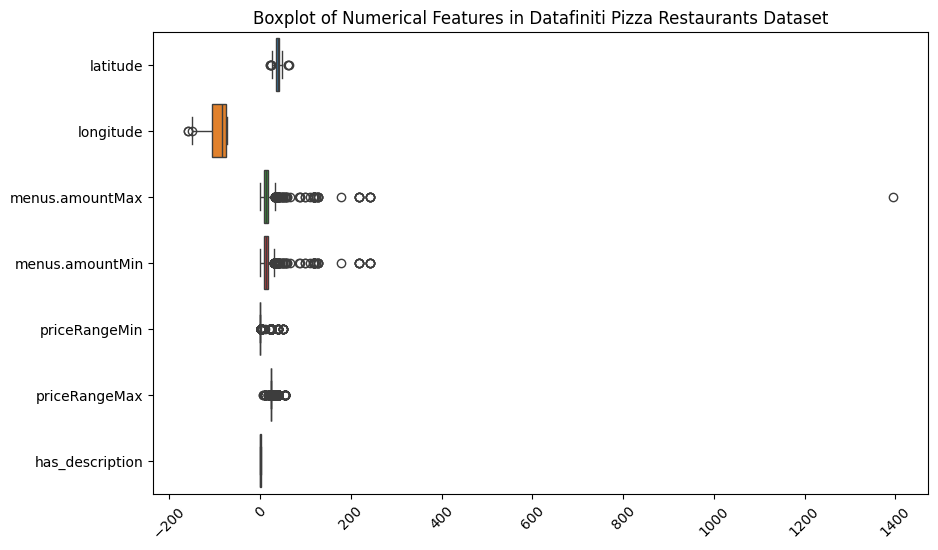

In [11]:
# Select numerical columns in Dataset 2
num_columns = data2_cleaned.select_dtypes(include=['float64','int64']).columns

# Boxplot for numerical features in Dataset 2
plt.figure(figsize=(10,6))
sns.boxplot(data=data2_cleaned[num_columns], orient='h')
plt.title('Boxplot of Numerical Features in Datafiniti Pizza Restaurants Dataset')
plt.xticks(rotation=45)
plt.show()


Menus.amountMax has an extreme outlier of a pizza that cost $1,395. This extreme value may be due to a data entry error or an expensive restaurant selling a luxury pizza. The outlier can be removed for analysis.

In [12]:
# remove the outlier in menus.amountMax
data2_cleaned = data2_cleaned[data2_cleaned['menus.amountMax']<500]


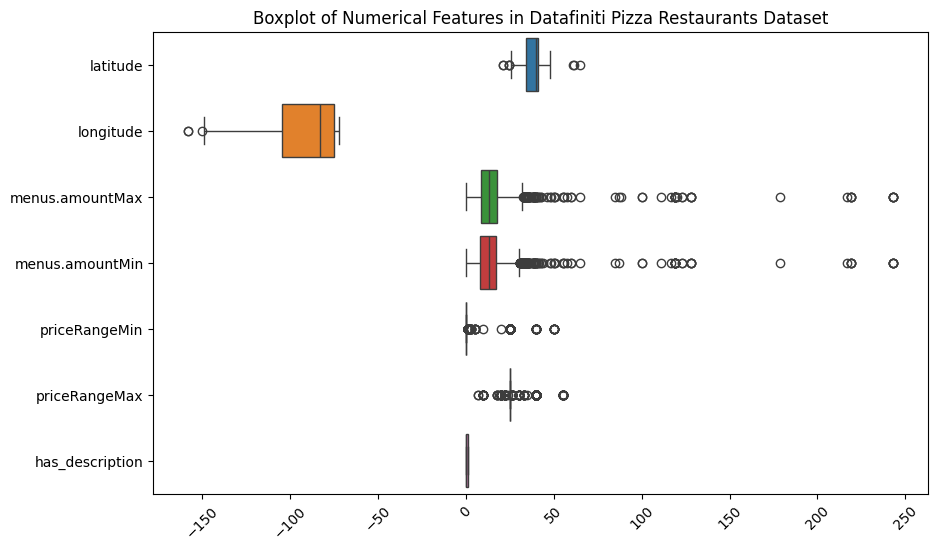

In [13]:
# Recheck data distribution after removig outlier
# Boxplot for numerical features in Dataset 2
plt.figure(figsize=(10,6))
sns.boxplot(data=data2_cleaned[num_columns], orient='h')
plt.title('Boxplot of Numerical Features in Datafiniti Pizza Restaurants Dataset')
plt.xticks(rotation=45)
plt.show()

A clear distribution of numerical features becomes visible once the extreme outlier is removed. 

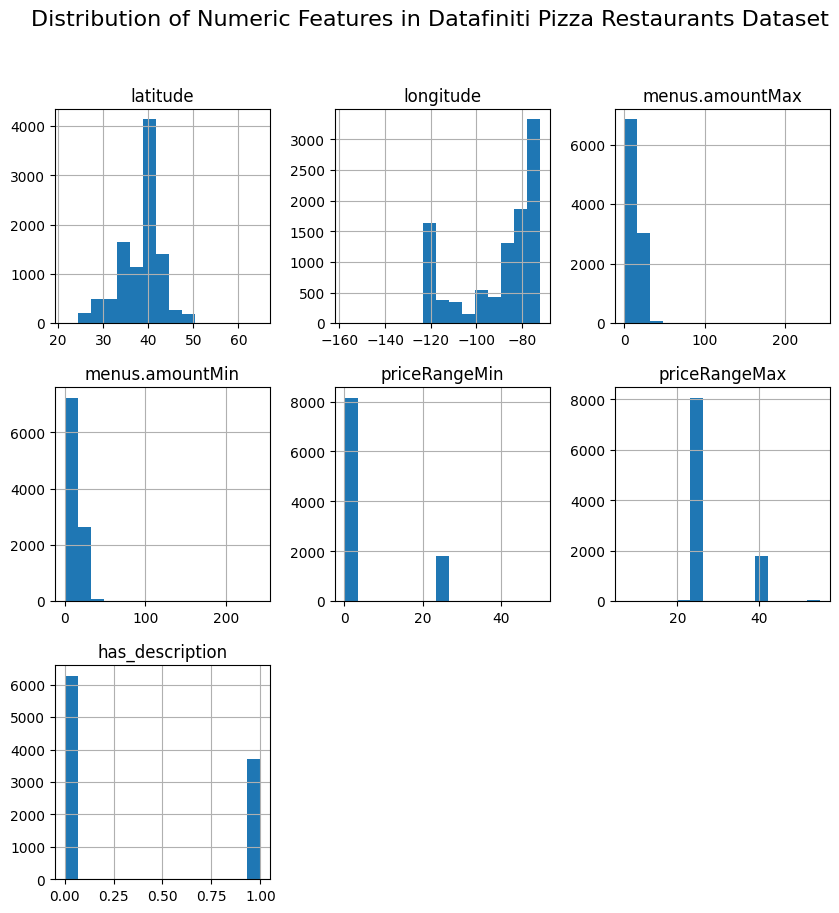

In [14]:
# Feature distribution of numeric features in Dataset 2 
data2_cleaned[num_columns].hist(figsize=(10,10),bins=15)
plt.suptitle("Distribution of Numeric Features in Datafiniti Pizza Restaurants Dataset", fontsize =16)
plt.show()

The histogram also provides a clear visualization of the distribution of the numeric feature. 

Longitude and latitude are continuous variables and display pizza location information.

- Options: keep as is, view mapping, compute distance reference point, group into regions, or use postal code/ city/ province/state to group instead of raw coordinates. 

menus.amount Max and Min are continuous variables that display the price range of menu items. These variables are skewed right. (may need normalization/transformation for modeling)

priceRange Min and Max look as though they are categorical variables with numeric values. Likely displaying similar information to menus.amount Max and Min.

has_description is a binary variable that indicates whether the menu item has a description. This variable was created from the menus.description variable, which had many missing values. 

<Axes: >

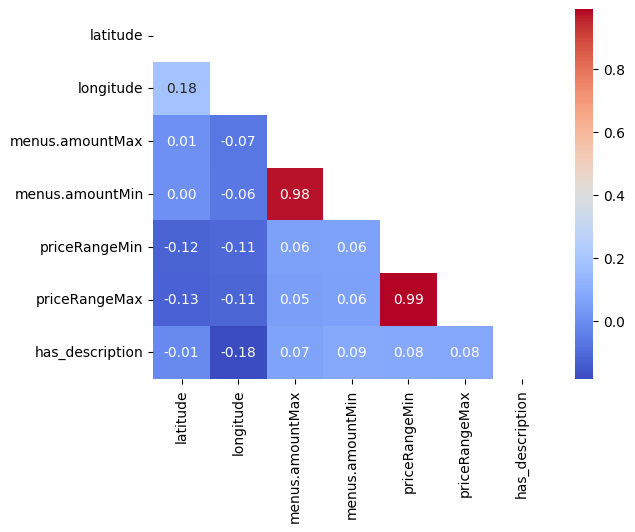

In [15]:
# Plot heatmap to visualize correlations
plt.figuresize=(10,8)
# creating mask to display only one triangle of the heatmap
mask = np.triu(np.ones_like(data2_cleaned[num_columns].corr()))

sns.heatmap(data2_cleaned[num_columns].corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)

Menus.amountMin and menus.amountMax are highly correlated (r = 0.98). 
- Combine the average of these variables for a more flexible option of modeling pricing.

priceRangeMin and priceRangeMax are also highly correlated (r = 0.99). 
- Combine the average of these variables for a more flexible option of modeling pricing.

All other numeric features have low correlation and can be kept as is for modeling.

In [16]:
# Combine highly correlated features into average features
data2_cleaned['menus_amount_avg'] = (data2_cleaned['menus.amountMin'] + data2_cleaned['menus.amountMax']) / 2
data2_cleaned['priceRange_avg'] = (data2_cleaned['priceRangeMin'] + data2_cleaned['priceRangeMax']) / 2 
# Drop original highly correlated features
data2_cleaned = data2_cleaned.drop(columns=['menus.amountMin', 'menus.amountMax', 'priceRangeMin', 'priceRangeMax'])

In [17]:
# Check the unique values across all columns in Dataset 2
data2_cleaned.nunique()

dateAdded             2214
dateUpdated           2193
primaryCategories        8
city                  1028
country                  1
latitude              2284
longitude             2284
menus.currency           1
menus.dateSeen        6303
menus.name            4749
name                  1827
postalCode            1771
priceRangeCurrency       1
province                44
has_description          2
menus_amount_avg       858
priceRange_avg          18
dtype: int64

**Timestamp variables**: dateAdded, dateUpdated, menus.dateSeen
- extract features: year, month, day, day of week, elapsed time since (for dateAdded and dateUpdated)
- drop after extracting features (high-cardinality categorical variable)

**Drop**

- County, meanus.currency, and priceRangeCurrency only have one unique value. These columns can be dropped.
- name high cardinality categorical variable, (not useful unless store-level predictions are needed) 
    - drop to prevent data leakage in linear models 
    - keep for tree-based models but group into top names vs other (will provide information on pricing strategies on chains vs independent restaurants)
- menus.name; Too high-cardinality unless top items are grouped. Will drop for now. 

**Leave as is**

has_description is a binary variable that was created to indicate if a menu has a description or not.

**one-hot encoded for modeling**

low-cardinality categorical variables: 
- primaryCategories: pizza type
- province: region-level location (linear models could group into larger regions)


One-hot encoding will occur in the model pipeline to avoid the dummy variable trap.


High-cardinality categorical variables: menus.dateSeen
- city: city-level location; could blow up the model with too many features. To capture city-level location, keep the top N cities and group the rest into "Other"
- postalCode: zip code-level location; could blow up model with too many features
    - drop in information already captured in other features

**Location**
longitude, latitude
- keep as continuous variables for tree-based models
- could compute distance from reference point (e.g., city center) or group into regions for linear models

**Dependent variables for modeling:**

priceRangeAverage or menus_amount_avg

Dependent Variable: Goal is to recommend pricing strategies for pizza restaurants.

Menu.amountMax: Maximum price of the menu item

- Continuous variable, good for regression modeling
- recommend exact menu pricing based on other features

or 

priceRangeMax: Maximum price of the price range

- Ordinal variable, good for classification modeling
- recommend price range categories based on other features (ie, budget, mid-range, premium)




In [18]:
# Drop variable with one unique value and high-cardinality variables
data2_cleaned = data2_cleaned.drop(columns=['country','menus.currency', 'priceRangeCurrency', 'postalCode', 'menus.name'])

## Handle Timestamp Variables

In [19]:
# check the formate of the data and time variables
print("dateAdded: \n", data2_cleaned['dateAdded'].head(2))
print("dateUpdated: \n", data2_cleaned['dateUpdated'].head(2))
print("menus.dateSeen: \n", data2_cleaned['menus.dateSeen'].head(2))


dateAdded: 
 0    2017-06-30T05:05:40Z
1    2016-04-02T04:02:49Z
Name: dateAdded, dtype: object
dateUpdated: 
 0    2019-05-01T15:43:09Z
1    2019-05-01T15:27:50Z
Name: dateUpdated, dtype: object
menus.dateSeen: 
 0    2018-05-01T04:25:37.197Z,2018-04-16T04:36:02.3...
1    2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...
Name: menus.dateSeen, dtype: object


dataAdded and dataUpdated can easily be converted to a datetime format.

Menus.dateSeen has many comma-separated values from multiple updates. Tricky to convert to a datetime format. 
- Dropping this variable will still capture price recommendations, but will lose seasonality trends in pricing.
- Keeping this variable will show seasonality trends in pricing, but will make modeling more difficult.
- Variable can be engineered into recency span to capture how long the menu has been tracked. 

In [20]:
# Change data formate of date columns to datetime data type
data2_cleaned['dateAdded'] = pd.to_datetime(data2_cleaned['dateAdded'], errors='coerce', utc=True)
data2_cleaned['dateUpdated'] = pd.to_datetime(data2_cleaned['dateUpdated'], errors='coerce', utc=True)

In [21]:
# Extract year, month, day, and day of week from dateAdded 
# data2_cleaned['dateAdded_year'] = data2_cleaned['dateAdded'].dt.year 
# year infromation is captured in days_since_added feature
data2_cleaned['dateAdded_month'] = data2_cleaned['dateAdded'].dt.month 
# data2_cleaned['dateAdded_day'] = data2_cleaned['dateAdded'].dt.day
# day infroamtion is captured in dateAdded_dayofweek feature 
data2_cleaned['dateAdded_dayofweek'] = data2_cleaned['dateAdded'].dt.dayofweek 
# Elapsed time since dateAdded 
data2_cleaned['days_since_added'] = (pd.Timestamp.now(tz='UTC') - data2_cleaned['dateAdded']).dt.days 

#  Extract year, month, day, and day of week from dateUpdated 
# data2_cleaned['dateUpdated_year'] = data2_cleaned['dateUpdated'].dt.year 
# year infromation is captured in days_since_updated feature
data2_cleaned['dateUpdated_month'] = data2_cleaned['dateUpdated'].dt.month 
# data2_cleaned['dateUpdated_day'] = data2_cleaned['dateUpdated'].dt.day 
# day infroamtion is captured in dateUpdated_dayofweek feature
data2_cleaned['dateUpdated_dayofweek'] = data2_cleaned['dateUpdated'].dt.dayofweek 
# Elapsed time since dateUpdated 
data2_cleaned['days_since_updated'] = (pd.Timestamp.now(tz='UTC') - data2_cleaned['dateUpdated']).dt.days 

In [22]:
# Compute recency span of menus.dateSeen
def date_span(s):
    if pd.isna(s): 
        return 0
    dates = [parser.parse(d) for d in str(s).split(',')]
    return (max(dates) - min(dates)).days if len(dates) > 1 else 0

data2_cleaned['menus_dates_span'] = data2_cleaned['menus.dateSeen'].apply(date_span)


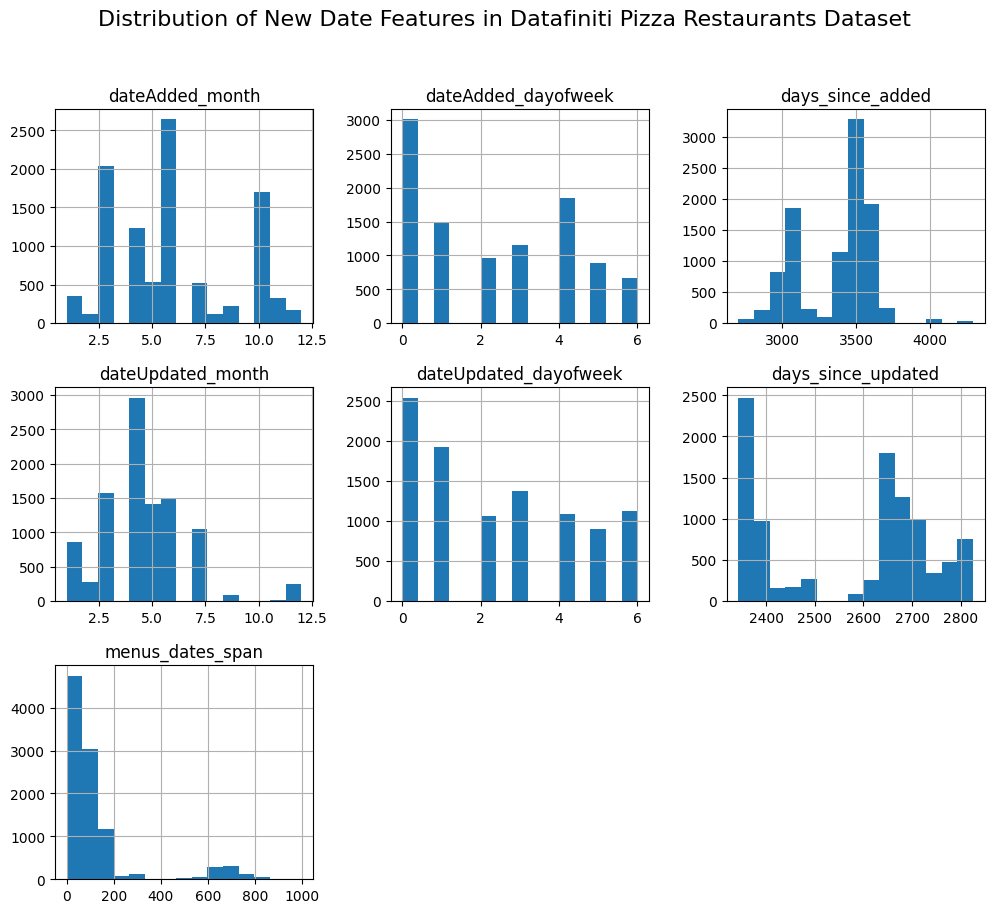

In [23]:
# visulize the distribution of the new date features
new_date_features = ['dateAdded_month', 'dateAdded_dayofweek',
                     'days_since_added', 'dateUpdated_month',
                     'dateUpdated_dayofweek', 'days_since_updated', 'menus_dates_span']
data2_cleaned[new_date_features].hist(figsize=(12,10), bins=15)
plt.suptitle("Distribution of New Date Features in Datafiniti Pizza Restaurants Dataset", fontsize=16)
plt.show()  

Month and days fo the week variable are categorical variables with numeric values. Can be one-hot encoded for linear modeling.

All other timestamp variables are continuous variables. 

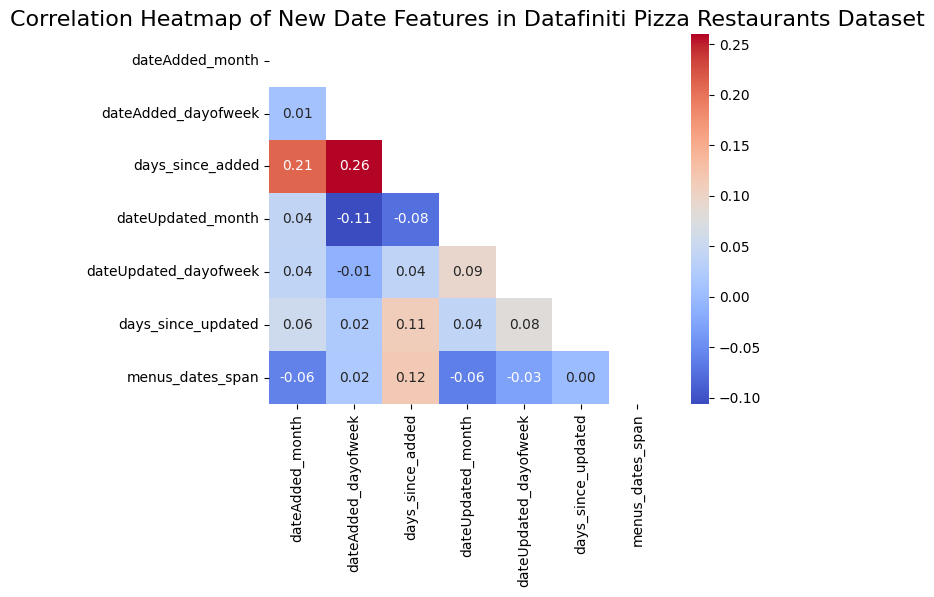

In [24]:
# Check the correlation of the new date features
plt.figuresize=(10,8)
# creating mask to display only one triangle of the heatmap
mask = np.triu(np.ones_like(data2_cleaned[new_date_features].corr()))
sns.heatmap(data2_cleaned[new_date_features].corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title("Correlation Heatmap of New Date Features in Datafiniti Pizza Restaurants Dataset", fontsize=16)
plt.show()

All timestap variables are showing low to moderate correlation with eachother.

In [25]:
# Drop original date columns
data2_cleaned = data2_cleaned.drop(columns=['dateAdded', 'dateUpdated', 'menus.dateSeen'])

In [26]:
# Check data types 
data2_cleaned.dtypes

primaryCategories         object
city                      object
latitude                 float64
longitude                float64
name                      object
province                  object
has_description            int64
menus_amount_avg         float64
priceRange_avg           float64
dateAdded_month            int32
dateAdded_dayofweek        int32
days_since_added           int64
dateUpdated_month          int32
dateUpdated_dayofweek      int32
days_since_updated         int64
menus_dates_span           int64
dtype: object

In [27]:
# All numeric features in Dataset 2
all_numeric_features = data2_cleaned.select_dtypes(include=['float64','int64', 'int32']).columns

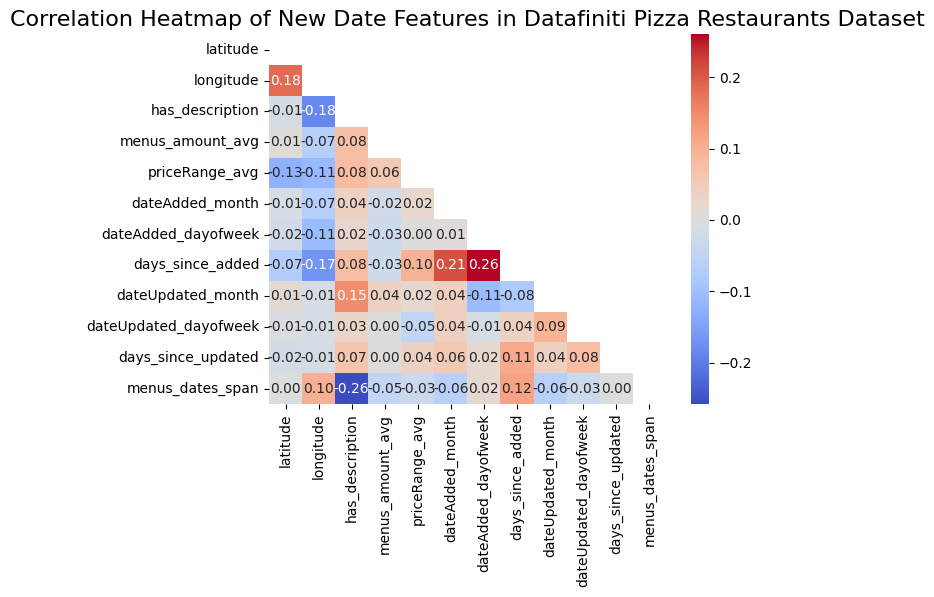

In [28]:
# Check correlation heatmap of all numeric features to ensure no other high correlations exist
plt.figuresize=(12,10)
# creating mask to display only one triangle of the heatmap
mask = np.triu(np.ones_like(data2_cleaned[all_numeric_features].corr()))
sns.heatmap(data2_cleaned[all_numeric_features].corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title("Correlation Heatmap of New Date Features in Datafiniti Pizza Restaurants Dataset", fontsize=16)
plt.show()

Most numeric features exhibit low correlation with one another. 

Additionally, there is a low correlation with the dependent variables' priceRangeAverage and menus_amount_avg. 

Linear relationships are weak, tree-based models may perform better.

## Longitude and Latitude and city 

- keep as continuous variables for tree-based models
- could compute distance from reference point (e.g., city center) or group into regions for linear models

- city: city-level location; could blow up the model with too many features. To capture city-level location, keep the top N cities and group the rest into "Other"

In [29]:
# Group into regions based on longitude and latitude
# Define function to categorize into regions
def categorize_region(lat, lon):
    if lat >= 40.0:
        return 'North'
    elif lat <= 30.0:
        return 'South'
    elif lon <= -120.0:
        return 'West'
    elif lon >= -80.0:
        return 'East'
    else:
        return 'Central'

data2_cleaned['region'] = data2_cleaned.apply(lambda row: categorize_region(row['latitude'], row['longitude']), axis=1)
# Keep region and drop original longitude and latitude for tree-based models

### Grouped Name Variable

In [30]:
# Create a grouped city variable
top_cities = data2_cleaned['city'].value_counts().nlargest(10).index
data2_cleaned['city_grouped'] = data2_cleaned['city'].apply(lambda x: x if x in top_cities else 'Other')
# Drop original city column
data2_cleaned = data2_cleaned.drop(columns=['city'])

In [31]:
# Create a grouped name variable
top_names = data2_cleaned['name'].value_counts().nlargest(10).index
data2_cleaned['name_grouped'] = data2_cleaned['name'].apply(lambda x: x if x in top_names else 'Other')
# Drop original name column
data2_cleaned = data2_cleaned.drop(columns=['name'])

In [32]:
# Group rare classes in priceRange_avg to avoid value error when splitting data into train and test sets with stratify=y
# Check the distribution of priceRange_avg
print(data2_cleaned['priceRange_avg'].value_counts())

priceRange_avg
12.5    7979
32.5    1801
13.5      54
13.0      31
11.5      28
47.5      21
10.5      18
15.0      16
5.0       16
52.5       9
17.5       8
16.5       5
10.0       4
14.0       4
3.5        2
18.0       1
14.5       1
25.0       1
Name: count, dtype: int64


In [33]:
# Group rare classes into 'Other'
rare_classes = data2_cleaned['priceRange_avg'].value_counts()[data2_cleaned['priceRange_avg'].value_counts() < 10].index
data2_cleaned['priceRange_avg'] = data2_cleaned['priceRange_avg'].apply(lambda x: 'Other' if x in rare_classes else x)

# Check the distribution again
print(data2_cleaned['priceRange_avg'].value_counts())

priceRange_avg
12.5     7979
32.5     1801
13.5       54
Other      35
13.0       31
11.5       28
47.5       21
10.5       18
15.0       16
5.0        16
Name: count, dtype: int64


10 main classes with average price ranges greater than 10 samples. Much more stable for classification.

## Data Wrangling and Pre-Processing

In [34]:
# Drop dependent variable not in use 
data2_cleaned = data2_cleaned.drop(columns=['menus_amount_avg']) # Target variable: recomended exact menue price 
# Separate features and target variable
X = data2_cleaned.drop(columns=['priceRange_avg'])
y = data2_cleaned['priceRange_avg'] # Target variable: recomended price range average 

priceRange_avg produced the value error " The least populated class in y has only one member, which is too few. The minimum number of groups for any class cannot be less than 2." When splitting the data into train and test sets with stratify=y. This error may be because priceRange_avg has a band with one sample.

menus_amount_avg is a continuous variable suitable for regression modeling. The goal is to recommend exact menu pricing based on other features.

priceRange_avg is an ordinal variable suitable for classification modeling. The goal is to recommend price range categories based on other features (ie, budget, mid-range, premium).

- Option to use priceRange_avg: group rare classes or bin into fewer categories to avoid value error when splitting data into train and test sets.

        **menus_amount_avg:** regression task (continuous target).

        **priceRange_avg:** classification task (discrete bins).

In [35]:
# Make all classes strings for classification modeling
y = y.astype(str)

### Data Splitting

In [36]:
# Split the data into training and validation sets
train_X, temp_X, train_y, temp_y = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

# Split validation data into validation and test sets
valid_X, test_X, valid_y, test_y = train_test_split(temp_X, temp_y, test_size=0.5, random_state=1, stratify=temp_y)

# Check the shape of the predictors in the datasets
print(train_X.shape, valid_X.shape, test_X.shape)

(5999, 15) (2000, 15) (2000, 15)


In [37]:
data2_cleaned.dtypes

primaryCategories         object
latitude                 float64
longitude                float64
province                  object
has_description            int64
priceRange_avg            object
dateAdded_month            int32
dateAdded_dayofweek        int32
days_since_added           int64
dateUpdated_month          int32
dateUpdated_dayofweek      int32
days_since_updated         int64
menus_dates_span           int64
region                    object
city_grouped              object
name_grouped              object
dtype: object

In [38]:
linear_features = ['primaryCategories','region','has_description','dateAdded_month', 'dateAdded_dayofweek',
                        'days_since_added', 'dateUpdated_month', 'dateUpdated_dayofweek', 'days_since_updated', 'menus_dates_span']

tree_features = ['primaryCategories', 'latitude', 'longitude','province','has_description','dateAdded_month', 'dateAdded_dayofweek',
                        'days_since_added', 'dateUpdated_month', 'dateUpdated_dayofweek', 'days_since_updated','menus_dates_span', 'city_grouped', 'name_grouped']

knn_features = ['primaryCategories', 'latitude', 'longitude','region','days_since_added', 'days_since_updated','menus_dates_span']

svm_features = ['primaryCategories','region','has_description','dateAdded_month', 'dateAdded_dayofweek','days_since_added', 'days_since_updated','menus_dates_span']

nn_features = ['primaryCategories', 'latitude', 'longitude','province','has_description','dateAdded_month', 'dateAdded_dayofweek',
                        'days_since_added', 'dateUpdated_month', 'dateUpdated_dayofweek', 'days_since_updated','menus_dates_span', 'city_grouped', 'name_grouped']
# Note: embeding featrues for nn may be better than one-hot encoding for high-cardinality categorical variables like city_grouped and name_grouped

In [39]:
# Create variables for modelign pipeline
# Linear
train_X_linear = train_X[linear_features].copy()
valid_X_linear = valid_X[linear_features].copy()
test_X_linear  = test_X[linear_features].copy()

# Tree
train_X_tree = train_X[tree_features].copy()
valid_X_tree = valid_X[tree_features].copy()
test_X_tree  = test_X[tree_features].copy()

# KNN
train_X_knn = train_X[knn_features].copy()
valid_X_knn = valid_X[knn_features].copy()
test_X_knn  = test_X[knn_features].copy()   

# SVM
train_X_svm = train_X[svm_features].copy()
valid_X_svm = valid_X[svm_features].copy()
test_X_svm  = test_X[svm_features].copy()

# NN
train_X_nn = train_X[nn_features].copy()
valid_X_nn = valid_X[nn_features].copy()    
test_X_nn  = test_X[nn_features].copy()

## Modeling Strategy

Uses a classification model to predict the price range within the price range categories. Then use regression to determine a specific price amount. 

Next steps:

Find the best classification model to predict priceRange_avg
- Hyperparameter tuning with GridSearchCV or RandomizedSearchCV
- Evaluate model performance with cross-validation

Find the best regression model to predict menus_amount_avg
- Hyperparameter tuning with GridSearchCV or RandomizedSearchCV
- Evaluate model performance with cross-validation

**Modeling methods ideas:**

- Idea 1: Two-step strategy. Use classification to predict the price range within the price range categories, then use regression to determine a specific price amount.
- Idea 2: Hierarchical classification strategy. Classify the region, then classify the price for that region.
- Idea 3: Single-Stage Strategy. Predict the price range given all features

**Preprocessing for model pipelines:**

In [40]:
# define numeric and categorical features for preprocessing steps in model pipeline
# Linear model preprocessing
lin_num = ['days_since_added', 'days_since_updated', 'menus_dates_span', 'has_description']
lin_cat = ['primaryCategories', 'region', 'dateAdded_month', 'dateUpdated_month','dateAdded_dayofweek', 'dateUpdated_dayofweek']

# Preprocessing for categorical data: OneHotEncoder (handle unknown categories in test set)
linear_pre = ColumnTransformer([
    ('num', StandardScaler(), lin_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), lin_cat)
], remainder='drop')

In [41]:
# define numeric and categorical features for preprocessing steps in model pipeline
# Tree model preprocessing
tree_num = ['latitude', 'longitude', 'days_since_added', 'days_since_updated', 'menus_dates_span', 'has_description']
tree_cat = ['primaryCategories', 'province', 'city_grouped', 'name_grouped', 'dateAdded_month', 'dateUpdated_month','dateAdded_dayofweek', 'dateUpdated_dayofweek']

# Preprocessing for categorical data: OneHotEncoder (handle unknown categories in test set)
tree_pre = ColumnTransformer([
    ('num', 'passthrough', tree_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), tree_cat)
], remainder='drop')

In [42]:
# define numeric and categorical features for preprocessing steps in model pipeline
# KNN model preprocessing
# KNN models require feature scaling for numeric features
knn_num = ['latitude', 'longitude', 'days_since_added', 'days_since_updated', 'menus_dates_span']
knn_cat = ['primaryCategories', 'region']

# preprocessing for KNN, SVM, and NN models
knn_pre = ColumnTransformer([
    ('num', StandardScaler(), knn_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), knn_cat)
], remainder='drop')    

In [43]:
# define numeric and categorical features for preprocessing steps in model pipeline
# SVM model preprocessing
# SVM models require feature scaling for numeric features
svm_num = ['days_since_added', 'days_since_updated', 'menus_dates_span', 'has_description']
svm_cat = ['primaryCategories', 'region', 'dateAdded_month', 'dateAdded_dayofweek']
# Preprocessing for categorical data: OneHotEncoder (handle unknown categories in test set)
svm_pre = ColumnTransformer([
    ('num', StandardScaler(), svm_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), svm_cat)
], remainder='drop')

In [44]:
# define numeric and categorical features for preprocessing steps in model pipeline
# NN model preprocessing
# NN models require feature scaling for numeric features
nn_num = ['latitude', 'longitude', 'days_since_added', 'days_since_updated', 'menus_dates_span', 'has_description']
nn_cat = ['primaryCategories', 'province', 'city_grouped', 'name_grouped', 'dateAdded_month', 'dateUpdated_month','dateAdded_dayofweek', 'dateUpdated_dayofweek']   
# Preprocessing for categorical data: OneHotEncoder (handle unknown categories in test set)
nn_pre = ColumnTransformer([
    ('num', StandardScaler(), nn_num),      
    ('cat', OneHotEncoder(handle_unknown='ignore'), nn_cat)
], remainder='drop')

Data is preprocessed and ready to be used in model pipelines.

# Validation and Testing 

# Results and final model selection

# Discussion and Conclusion